In [1]:
# import of the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, export_text
from IPython.display import Image
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc, average_precision_score
from sklearn.model_selection import train_test_split

In [2]:
file_excel = pd.ExcelFile('Needs.xls')

nomi = file_excel.sheet_names

nome_foglio = nomi[0]
clients = pd.read_excel(file_excel, sheet_name=nome_foglio)
nome_foglio = nomi[1]
products = pd.read_excel(file_excel, sheet_name=nome_foglio)

print(clients.head())
print(products.head())


   ID  Age  Gender  FamilyMembers  FinancialEducation  RiskPropensity  \
0   1   60       0              2            0.228685        0.233355   
1   2   78       0              2            0.358916        0.170911   
2   3   33       1              2            0.317515        0.249703   
3   4   69       1              4            0.767685        0.654597   
4   5   58       0              3            0.429719        0.349039   

      Income       Wealth  IncomeInvestment  AccumulationInvestment  
0   68.181525   53.260067                 0                       1  
1   21.807595  135.550048                 1                       0  
2   23.252747   66.303678                 0                       1  
3  166.189034  404.997689                 1                       1  
4   21.186723   58.911930                 0                       0  
   IDProduct  Type  Risk
0          1     1  0.55
1          2     0  0.30
2          3     0  0.12
3          4     0  0.44
4          5    

Splitting data between training and testing

-> 80% of the data in the dataset I use for training, the remainder for testing
-> Using current income as label Investments next idea is to create a correspondence between data and product

In [3]:
# ASSEGNARE CLIENTS LA LABEL CON LA COSTRUZIONE DELLA FORMULA
clients['key'] = 1
products['key'] = 1
df = pd.merge(clients, products, on='key')
df.drop('key', axis=1, inplace=True)
clients.drop('key', axis=1, inplace=True)
products.drop('key', axis=1, inplace=True)

# CREATION OF THE FLAG
df['flag'] = 0

for index, row in df.iterrows():
    if ((row['IncomeInvestment'] == 1 and row['Type'] == 0) or (row['AccumulationInvestment'] == 1 and row['Type'] == 1)) and row['RiskPropensity'] >= row['Risk']:
        df.at[index, 'flag'] = 1

print(df.head())

X = df.drop(['ID', 'IDProduct', 'flag'], axis=1)

print(X.head())

# SEPARATION OF THE DATA SET IN TRAIN, TEST AND VALIDATION
train_predictors, rest_predictors, train_response, rest_response = train_test_split(
       # input matrix senza la label - vettori delle label
       X, df['flag'], train_size=0.7, random_state=0)

validation_predictors, test_predictors, validation_response, test_response = train_test_split(
rest_predictors, rest_response, train_size=0.5, random_state=0)

name_columns_train = X.columns
print(name_columns_train)


   ID  Age  Gender  FamilyMembers  FinancialEducation  RiskPropensity  \
0   1   60       0              2            0.228685        0.233355   
1   1   60       0              2            0.228685        0.233355   
2   1   60       0              2            0.228685        0.233355   
3   1   60       0              2            0.228685        0.233355   
4   1   60       0              2            0.228685        0.233355   

     Income      Wealth  IncomeInvestment  AccumulationInvestment  IDProduct  \
0  68.181525  53.260067                 0                       1          1   
1  68.181525  53.260067                 0                       1          2   
2  68.181525  53.260067                 0                       1          3   
3  68.181525  53.260067                 0                       1          4   
4  68.181525  53.260067                 0                       1          5   

   Type  Risk  flag  
0     1  0.55     0  
1     0  0.30     0  
2     0  0.12 

Here there is the creation of the Decision Tree
After I want to identify the best hyperparameter of the DecisionTreeClassifier

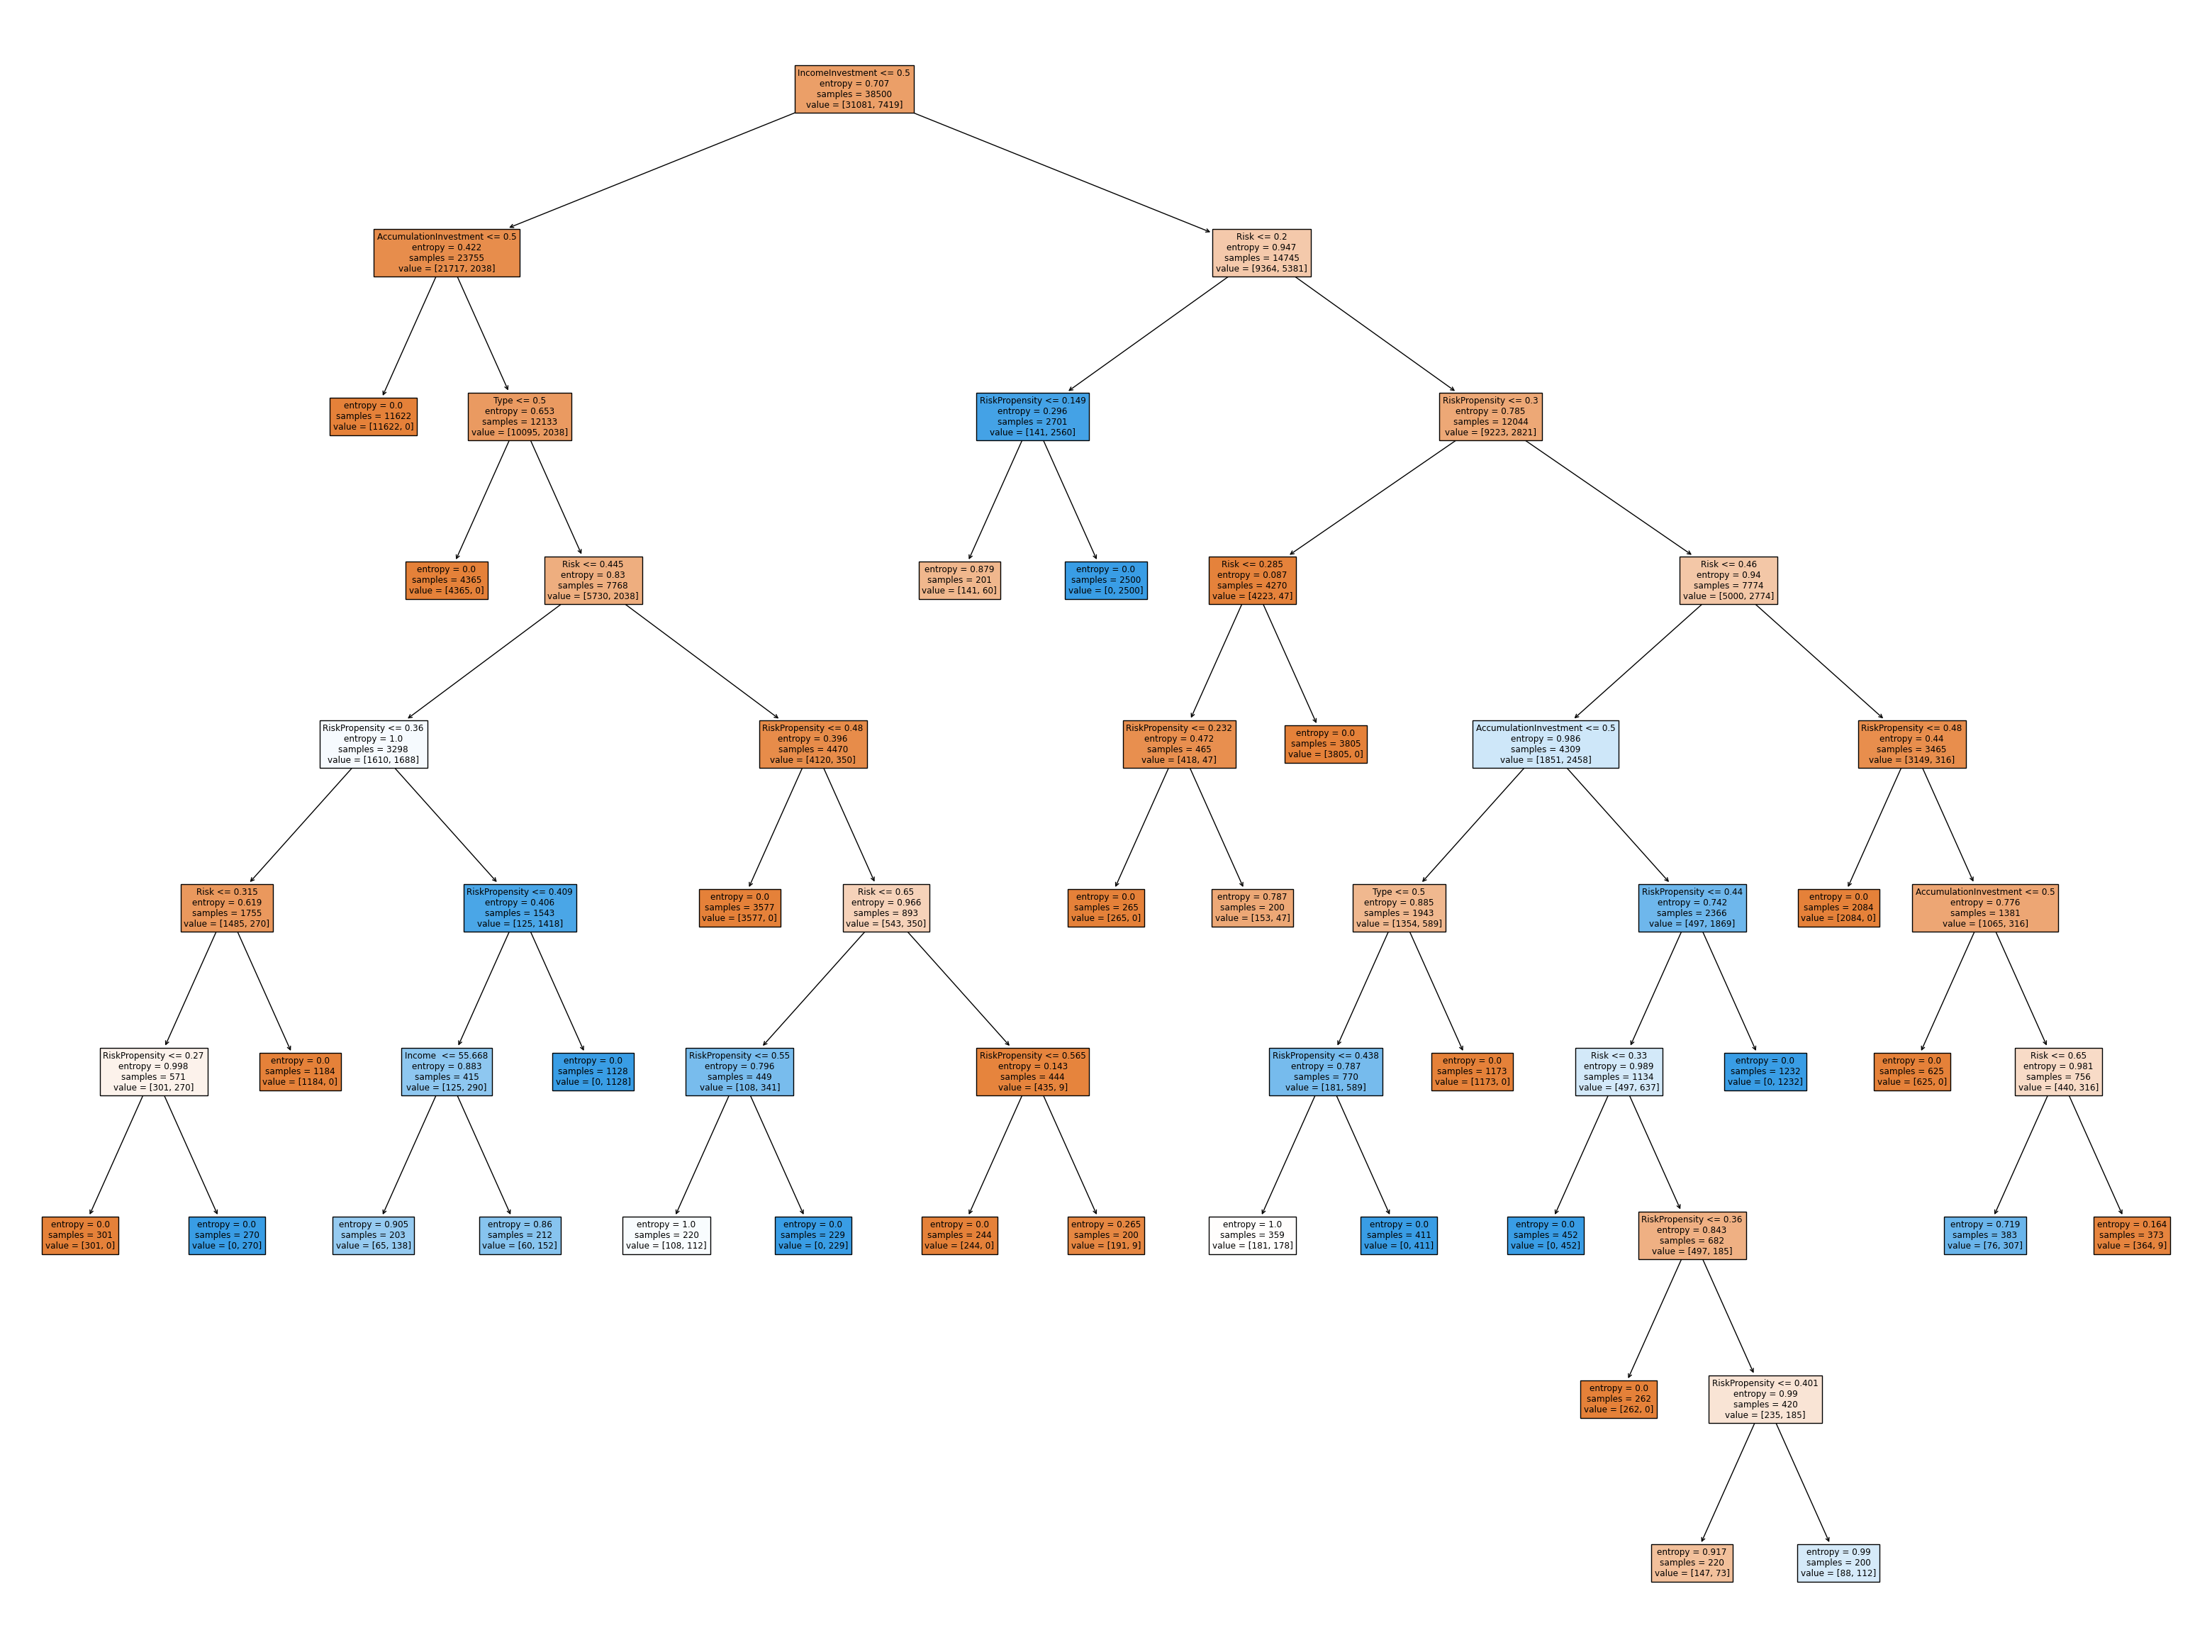

train:  Age                        61.000000
Gender                      0.000000
FamilyMembers               3.000000
FinancialEducation          0.541284
RiskPropensity              0.436427
Income                    128.651639
Wealth                    126.914473
IncomeInvestment            1.000000
AccumulationInvestment      1.000000
Type                        1.000000
Risk                        0.480000
Name: 21677, dtype: float64
test:  0
Q:  0.0


In [4]:
# FIRST TREE WITH NO MODIFICATION ON THE DATA
# train the tree classification => on incume

clf = DecisionTreeClassifier(criterion='entropy',max_depth=10,min_samples_split=200, min_samples_leaf=200,random_state=0)
clf = clf.fit(train_predictors, train_response)
fig, ax = plt.subplots(figsize=(40, 30))
plot_tree(clf, filled=True, feature_names=name_columns_train, proportion=False)
plt.show()

# EXSAMPLE OF THE OUTPUT
print("train: ",train_predictors.iloc[0])
print("test: ", train_response.iloc[0])

Q = clf.predict_proba(train_predictors)[0,1]
print("Q: ",  Q)

TOT_TEST:  38500


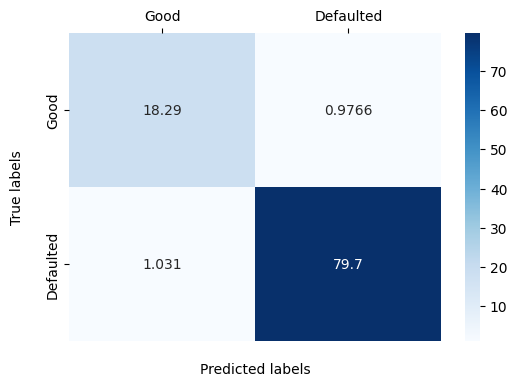

TRAIN AUC = 0.9984


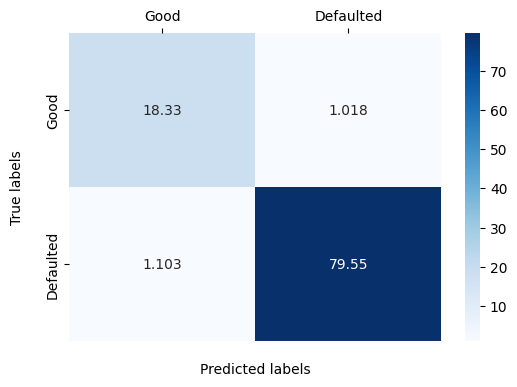

VALIDATION AUC = 0.9976


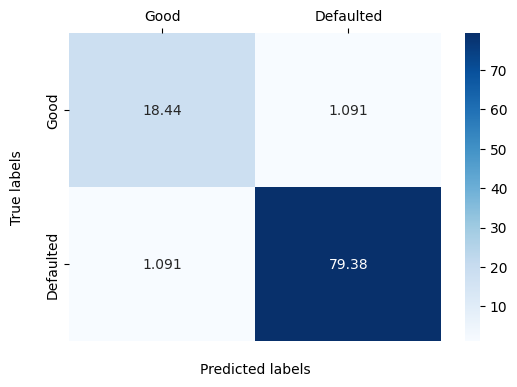

TEST AUC = 0.9979


In [5]:
# result of the predicition ON TRAINING SET
n_test = len(train_predictors)
print("TOT_TEST: ", n_test)
y_pred = clf.predict(train_predictors)
perc = clf.predict_proba(train_predictors)[:,1]

# IMPOSTAZIONE 1 = GOOD IN QUESTO SETTAGGIO
cm = (confusion_matrix(train_response, y_pred,labels=[1, 0], sample_weight=None)/n_test)*100
plt.figure(figsize=(6, 4))      # format the plot size
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='.4g', cmap="Blues")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['Good','Defaulted'],verticalalignment='center')
ax.xaxis.set_ticklabels(['Good','Defaulted'])
plt.show()

fpr, tpr, _ = roc_curve(train_response, perc)
roc_aucTRAIN = auc(fpr,tpr)

print("TRAIN AUC = %0.4f" %(roc_aucTRAIN))

# result of the predicition ON VALIDATION SET
n_test = len(validation_predictors)
y_pred = clf.predict(validation_predictors)
perc = clf.predict_proba(validation_predictors)[:,1]
cm = (confusion_matrix(validation_response, y_pred,labels=[1, 0], sample_weight=None)/n_test)*100
plt.figure(figsize=(6, 4))      # format the plot size
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='.4g', cmap="Blues")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['Good','Defaulted'],verticalalignment='center')
ax.xaxis.set_ticklabels(['Good','Defaulted'])
plt.show()

fpr, tpr, _ = roc_curve(validation_response, perc)
roc_aucVAL = auc(fpr,tpr)

print("VALIDATION AUC = %0.4f" %(roc_aucVAL))

# result of the predicition ON TEST SET
n_test = len(test_predictors)
y_pred = clf.predict(test_predictors)
perc = clf.predict_proba(test_predictors)[:,1]
cm = (confusion_matrix(test_response, y_pred,labels=[1, 0], sample_weight=None)/n_test)*100
plt.figure(figsize=(6, 4))      # format the plot size
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='.4g', cmap="Blues")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['Good','Defaulted'],verticalalignment='center')
ax.xaxis.set_ticklabels(['Good','Defaulted'])
plt.show()

fpr, tpr, _ = roc_curve(test_response, perc)
roc_aucTEST = auc(fpr,tpr)

print("TEST AUC = %0.4f" %(roc_aucTEST))


Here in order to understand the computation of the matrix I'd like to calculate the matrix by myself

In [6]:
# MANUAL COMPUTATION OF THE CONFUSION MATRIX

TP = 0
TN = 0
FP = 0
FN = 0
percentage = [0,0,0,0, 0]

train_ps = train_response.values

for pos in range(n_test):
    if train_ps[pos] == y_pred[pos]:
        if y_pred[pos]:
            TP += 1
        else:
            TN += 1
    else:
        if train_ps[pos] == 1 and y_pred[pos] == 0:
            FN += 1
        else:
            FP += 1
    

percentage[0] = TP / n_test
percentage[1] = TN / n_test
percentage[2] = FP / n_test
percentage[3] = FN / n_test

percentage[4] = (TP + TN) / n_test
print(percentage)

[0.037454545454545456, 0.6513939393939394, 0.15781818181818183, 0.15333333333333332, 0.6888484848484848]


The idea is to iterate through the hyperparameters to identify the best ones that determine the accuracy of the best model

In [7]:
# FACCIO DELLE PROVE A LIVELLO
n_test = len(train_predictors)

results = np.zeros((20000, 8))

j = 0    

max_dif = 0
pos_max = 0
# 8
for max_depth in range(2, 10):
    # 990
    for min_samples_split in range(10, 1000, 5):
        clf = DecisionTreeClassifier(criterion='entropy',max_depth=max_depth,min_samples_split=min_samples_split, min_samples_leaf=200,random_state=0)
        clf = clf.fit(train_predictors, train_response)

        y_pred_train = clf.predict(train_predictors)
        y_pred_val = clf.predict(validation_predictors)
        y_pred_test = clf.predict(test_predictors)
        # Q = clf.predict_proba(train)[0,1]
        # cm_train = (confusion_matrix(train_response, y_pred_train,labels=[1, 0], sample_weight=None)/n_test)*100
        # cm_val = (confusion_matrix(train_response, y_pred_train,labels=[1, 0], sample_weight=None)/n_test)*100
        """
        TP = cm[0][0]                                                                                          # True Positives
        FN = cm[0][1]                                                                                          # False Positives
        FP = cm[1][0]                                                                                          # True Negatives
        TN = cm[1][1] 
        """                                                                                     # False Negatives
        
        #  I can create a petrich with the weightss
        results[j][0] = accuracy_score(train_response, y_pred_train)
        results[j][1] = accuracy_score(validation_response, y_pred_val)
        results[j][2] = accuracy_score(test_response, y_pred_test)

        dif = results[j][0] - results[j][1]
        """å
        results[j][1] = recall_score(test_y_income, y_pred)
        results[j][2] = TN/(FP+TN)                                                                         # True negative rate
        results[j][3] = FP/(FP+TN)                                                                         # False positive rate
        results[j][4] = precision_score(test_y_income, y_pred)
        results[j][5] = f1_score(test_y_income, y_pred)
        """
        results[j][3] = max_depth
        results[j][4] = min_samples_split
    

        if dif > max_dif:
            print(str(j)+" - Accuracy Train: "+str(results[j][0])+ " - Accuracy Val: "+ str(results[j][1])+" - Accuracy Test: "+ str(results[j][2]))
            pos_max = j
            max_dif = dif
        # print(str(j)+" - Accuracy Train: "+str(results[j][0])+ " - Accuracy Val: "+ str(results[j][1]))
        j += 1


print("NUMBER OF TESTS: ",j)

analisi = pd.DataFrame(results)

massimo_colonna_A = analisi[2].max()
indici_righe_massimo_A = analisi.index[analisi[2] == massimo_colonna_A].tolist()

print(analisi)

parametrics = np.zeros((len(indici_righe_massimo_A), 2))

i = 0

for pos in indici_righe_massimo_A:
    parametrics[i][0] = results[pos][3]
    parametrics[i][1] = results[pos][4]

    i += 1


analisi = pd.DataFrame(parametrics)

# QUI SONO TUTTI I MODELLI CHE DANNO LO STESSO VALORE DI ACCURATEZZA NEL TRAIN SET
print("Analisi: ", analisi)


0 - Accuracy Train: 0.8701298701298701 - Accuracy Val: 0.867030303030303 - Accuracy Test: 0.8699393939393939
198 - Accuracy Train: 0.8722337662337663 - Accuracy Val: 0.8686060606060606 - Accuracy Test: 0.8711515151515151
1103 - Accuracy Train: 0.9722857142857143 - Accuracy Val: 0.9683636363636363 - Accuracy Test: 0.9706666666666667
1140 - Accuracy Train: 0.9662857142857143 - Accuracy Val: 0.9618181818181818 - Accuracy Test: 0.9642424242424242
1143 - Accuracy Train: 0.9662077922077922 - Accuracy Val: 0.9615757575757575 - Accuracy Test: 0.9648484848484848
NUMBER OF TESTS:  1584
             0        1         2    3     4    5    6    7
0      0.87013  0.86703  0.869939  2.0  10.0  0.0  0.0  0.0
1      0.87013  0.86703  0.869939  2.0  15.0  0.0  0.0  0.0
2      0.87013  0.86703  0.869939  2.0  20.0  0.0  0.0  0.0
3      0.87013  0.86703  0.869939  2.0  25.0  0.0  0.0  0.0
4      0.87013  0.86703  0.869939  2.0  30.0  0.0  0.0  0.0
...        ...      ...       ...  ...   ...  ...  ...  .

Now I identify the best model that I have found before

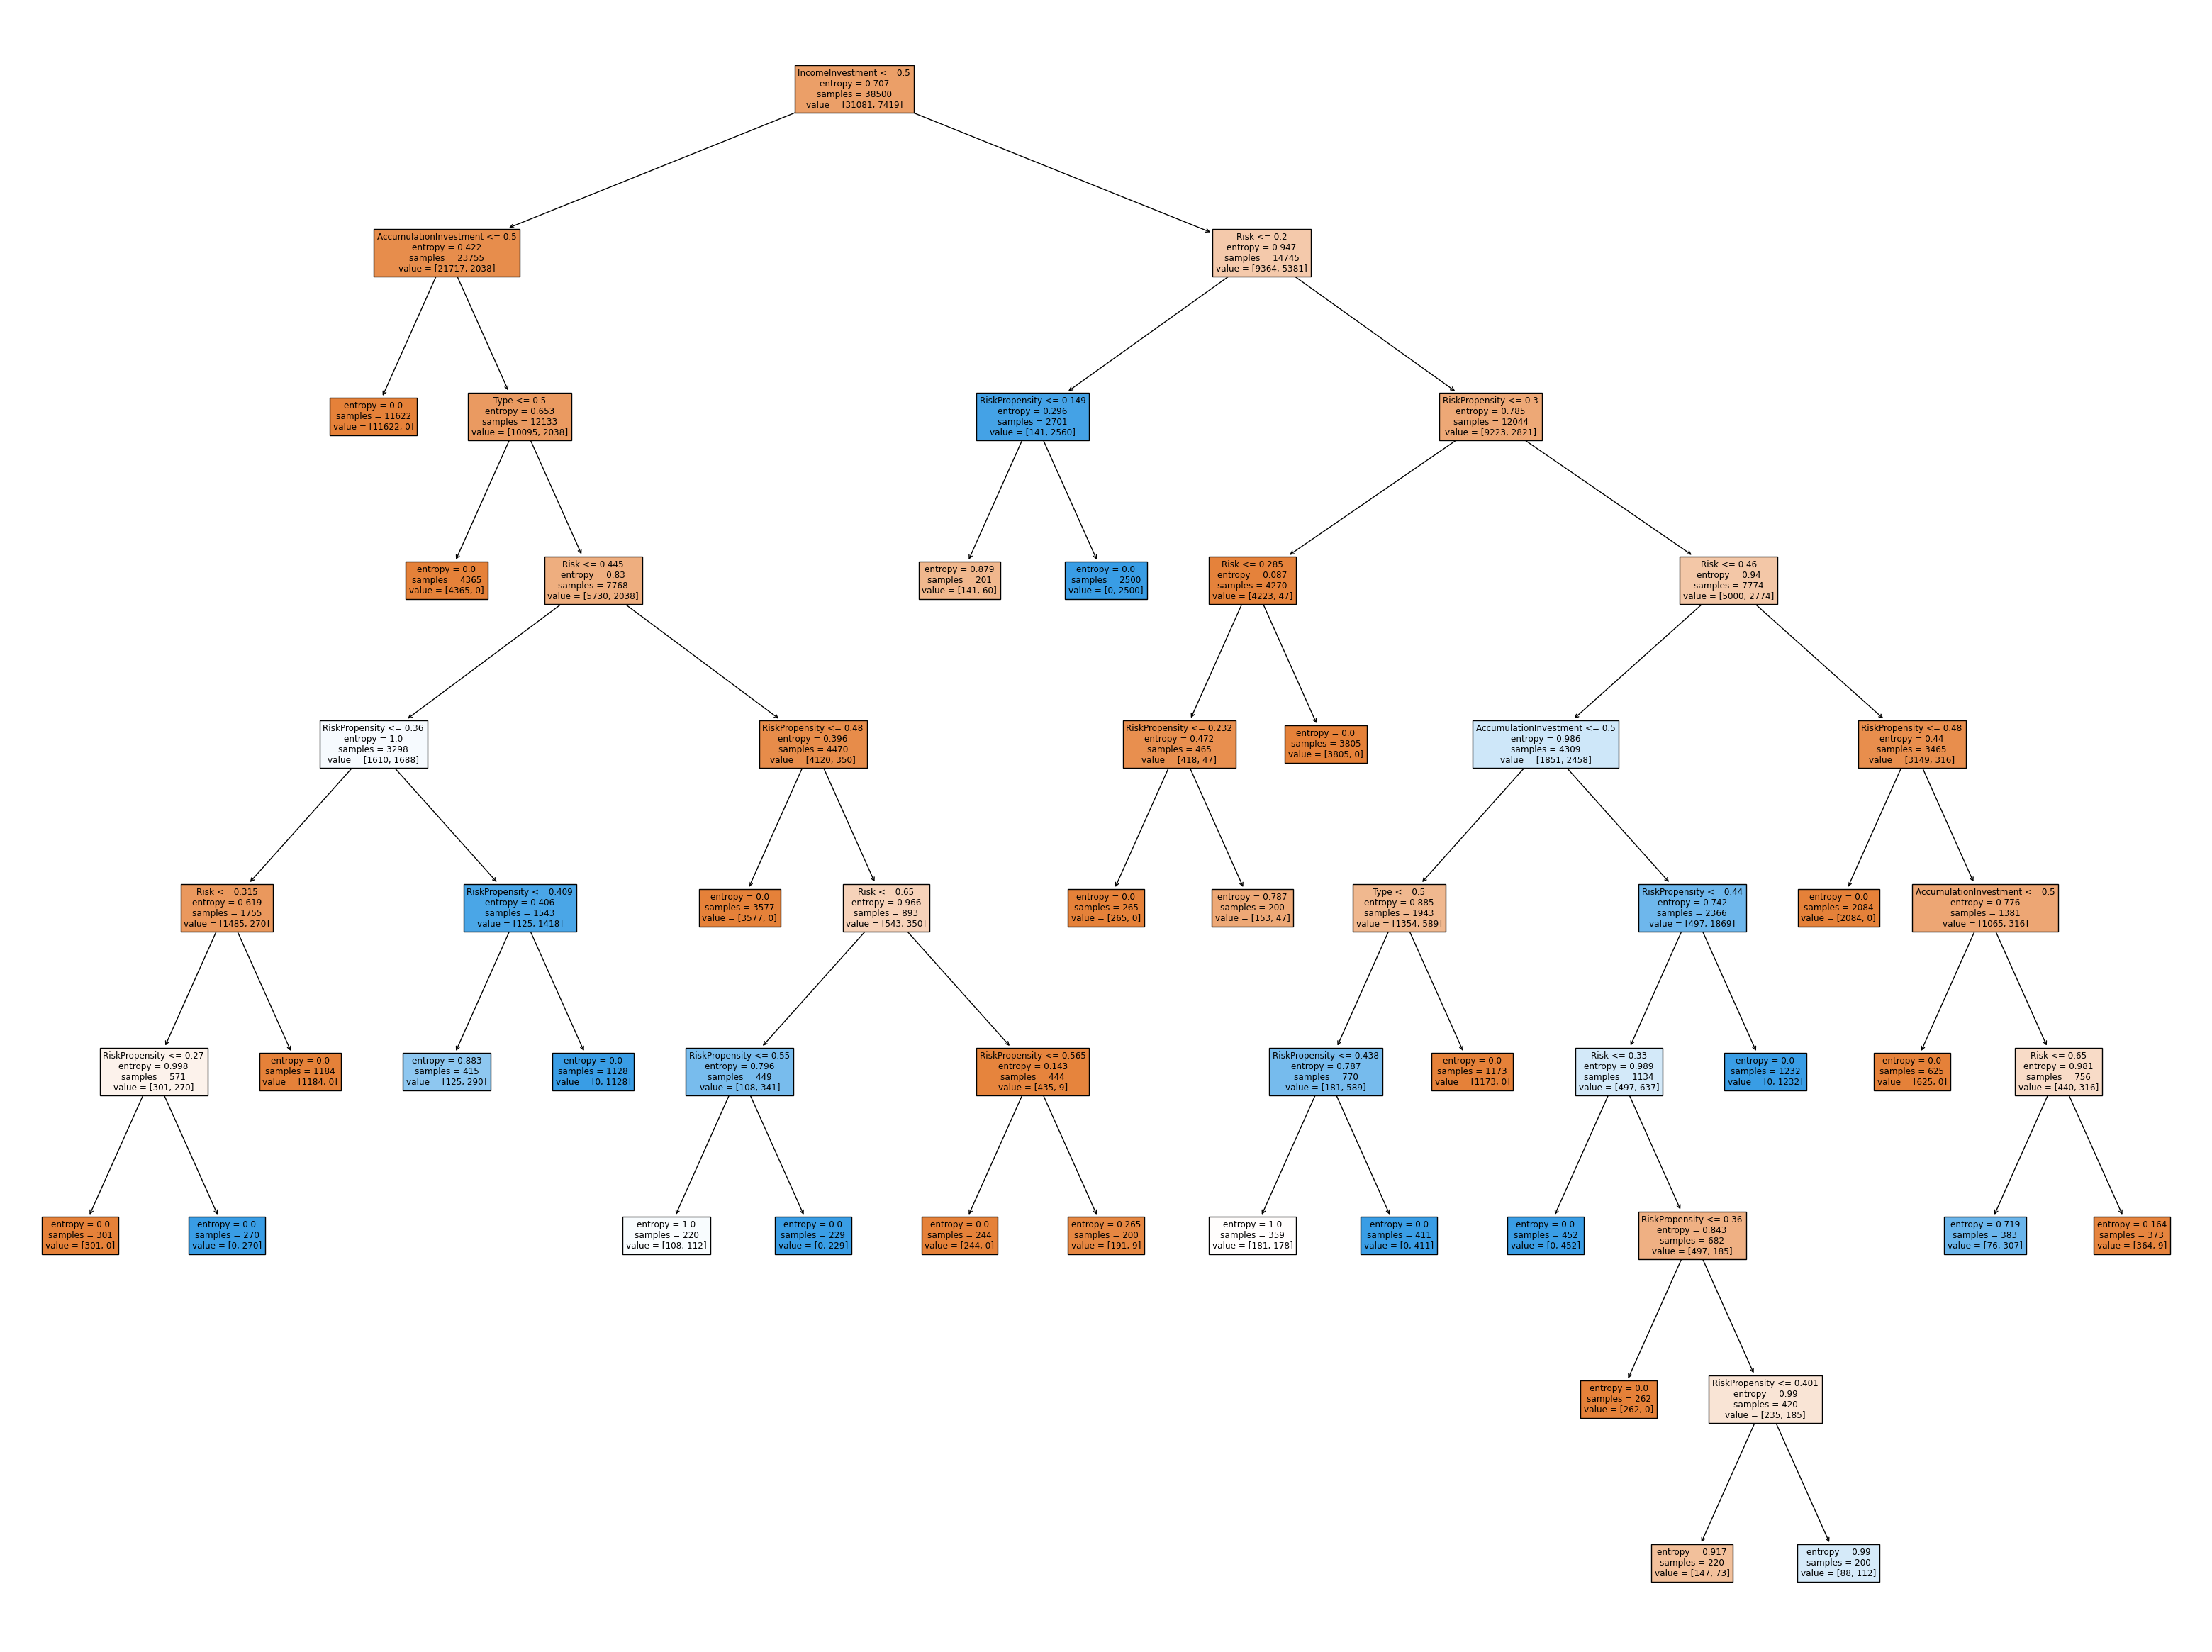

In [8]:
try_tree = DecisionTreeClassifier(criterion='entropy',max_depth=9,min_samples_split=420, min_samples_leaf=200,random_state=0)
try_tree = try_tree.fit(train_predictors, train_response)
fig, ax = plt.subplots(figsize=(40, 30))
plot_tree(try_tree, filled=True, feature_names=name_columns_train, proportion=False)
plt.show()

TOT_TEST:  8250


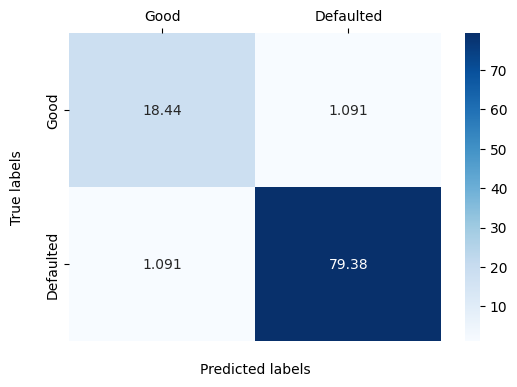

In [12]:
# result of the predicition
n_test = len(test_predictors)
print("TOT_TEST: ", n_test)
y_pred_try = try_tree.predict(test_predictors)
perc = try_tree.predict_proba(test_predictors)[:,1]

# IMPOSTAZIONE 1 = GOOD IN QUESTO SETTAGGIO
cm = (confusion_matrix(test_response, y_pred_try,labels=[1, 0], sample_weight=None)/n_test)*100
plt.figure(figsize=(6, 4))      # format the plot size
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='.4g', cmap="Blues")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['Good','Defaulted'],verticalalignment='center')
ax.xaxis.set_ticklabels(['Good','Defaulted'])
plt.show()

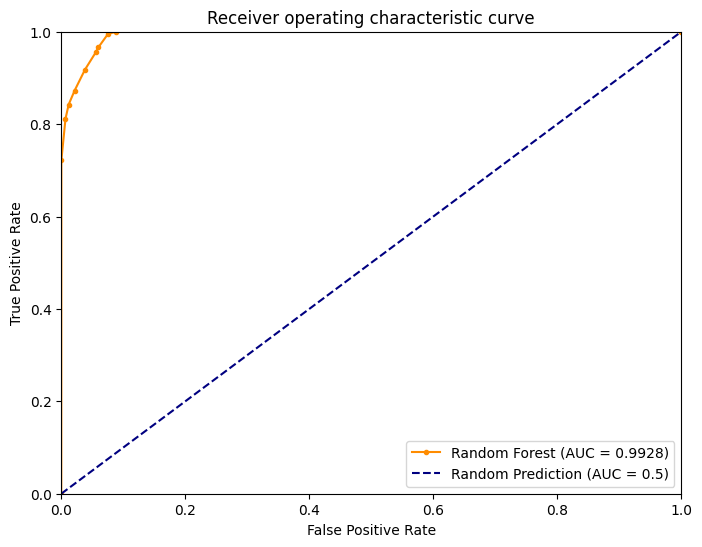

In [13]:
# RAPPRESENTAZIONE CON L'AREA
Q = clf.predict_proba(test_predictors)[:,1]

fpr, tpr, _ = roc_curve(test_response, Q)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8,6))      # format the plot size
lw = 1.5
plt.plot(fpr, tpr, color='darkorange', marker='.',
         lw=lw, label='Random Forest (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Prediction (AUC = 0.5)' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()